<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-изучение-общей-информации" data-toc-modified-id="Загрузка-данных-и-изучение-общей-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и изучение общей информации</a></span></li><li><span><a href="#Удаление-неинформативных-признаков" data-toc-modified-id="Удаление-неинформативных-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Удаление неинформативных признаков</a></span></li><li><span><a href="#Проверка-на-наличие-явных-дубликатов" data-toc-modified-id="Проверка-на-наличие-явных-дубликатов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Проверка на наличие явных дубликатов</a></span></li><li><span><a href="#Очистка,-лемматизация-и-разделение-данных-на-выборки" data-toc-modified-id="Очистка,-лемматизация-и-разделение-данных-на-выборки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Очистка, лемматизация и разделение данных на выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-DecisionTreeClassifier" data-toc-modified-id="Модель-DecisionTreeClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель DecisionTreeClassifier</a></span></li><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель LogisticRegression</a></span></li><li><span><a href="#Модель-SGDClassifier" data-toc-modified-id="Модель-SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель SGDClassifier</a></span></li><li><span><a href="#Модель-LGBMClassifier" data-toc-modified-id="Модель-LGBMClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель LGBMClassifier</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо:
- обучить модель классифицировать комментарии на позитивные и негативные;
- значением метрики качества модели `F1` должна быть не меньше 0.75.

В распоряжении набор данных с разметкой о токсичности правок `toxic_comments.csv`:
- столбец `text` содержит текст комментария
- столбец `toxic` — целевой признак.

## Подготовка

### Загрузка данных и изучение общей информации

Импортируем (установим) все необходимые для выполнения проекта библиотеки:

In [1]:
!pip install --upgrade pip -q
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2 -q
!pip install --upgrade Pillow==9.4.0 -q

In [2]:
import pandas as pd
import os
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np

from wordcloud import WordCloud

from nltk.corpus import stopwords as nltk_stopwords

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, confusion_matrix

Загрузим данные с комментариями и посмотрим на них

In [3]:
# пути к датафрейму toxic_comments в тренажере и локально
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

# считываем данные и сохраняем в переменную toxic_comments
if os.path.exists(pth1):
    toxic_comments = pd.read_csv(pth1)
elif os.path.exists(pth2):
    toxic_comments = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
# выводим случайные 10 строк toxic_comments
toxic_comments.sample(10, random_state=42)

,Unnamed: 0,text,toxic
31015,31055,"Sometime back, I just happened to log on to ww...",0
102832,102929,"""\n\nThe latest edit is much better, don't mak...",0
67317,67385,""" October 2007 (UTC)\n\nI would think you'd be...",0
81091,81167,Thanks for the tip on the currency translation...,0
90091,90182,I would argue that if content on the Con in co...,0
1860,1860,"""=Reliable sources===\nCheating:\n""""Barry Bond...",1
125293,125422,WTF=\n\nHow The Fuck Does This Person Merit A ...,1
148986,149142,"cajuns, acadians\nCajuns, acadians, louisianan...",0
89697,89784,Hi - I dropped a pin in Google Maps at the cer...,0
64256,64323,Re removal of accessdate= for urls books \n\nT...,0


Посмотрим на иформацию о датафрейме:

In [5]:
# информация о датафрейме
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В нашем распоряжении 159 292 коментария, пропусков в данных нет.

### Удаление неинформативных признаков

Столбец `Unnamed: 0` выглядит как столбец с индексами, только чем больше индекс тем больше значения столбца, как-будто какие-то строки пропали, удалим этот столбец, т.к. никакой пользы от него нет:

In [6]:
# удаление неинформативного столбца
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)

print(f'Размер датафрейма toxic_comments: {toxic_comments.shape}')

Размер датафрейма toxic_comments: (159292, 2)


Датафрейм уменьшился на 1 столбец.

### Проверка на наличие явных дубликатов

Проверим датафрейм н наличие явных комментариев:

In [7]:
# проверка на наличие явных дубликатов
print(f'Количество явных дубликатов: {toxic_comments.duplicated().sum()}')

Количество явных дубликатов: 0


Дубликатов нет.

### Очистка, лемматизация и разделение данных на выборки

Создадм функцию для очистки и лемматизации комментариев и применим её к датафрейму:

In [8]:
# функция для очистки и лематизации комментариев
def clear_and_lemmatize(df, column, target):
    # df - датафрейм
    # column - столбец с коментариями
    # target - целевой признак
    
    # создание копии датафрейма
    data = df.copy()
    
    # замена лишних символов на пропуск
    data['text_1'] = data[column].apply(lambda x: re.sub(r'[^a-zA-Z ]', ' ', x.lower()))
    
    # разделение и обратное соединение оставшихся слов
    data['text_2'] = data['text_1'].apply(lambda x: ' '.join(x.split()))
    
    # создание языковой модели лемматизации
    nlp = spacy.load('en_core_web_sm')
    
    # лемматизаця комментариев
    lemma = []
    for doc in nlp.pipe(data['text_2'].values):
        lemma.append(' '.join([n.lemma_ for n in doc]))
        
    return pd.DataFrame({'lemm_text': lemma, 'toxic': data['toxic']})

In [9]:
# получение очищенного и лемматизированного датафрейма
toxic_comments_lemm = clear_and_lemmatize(toxic_comments, 'text', 'toxic')

In [10]:
# сравнение размеров до и после очищения и лемматизации
pd.DataFrame([[toxic_comments.shape], [toxic_comments_lemm.shape]],
            index=['Исходный датафрейм', 'Очищенный и лемматизированный датафрейм'],
            columns=['Размер'])

,Размер
Исходный датафрейм,"(159292, 2)"
Очищенный и лемматизированный датафрейм,"(159292, 2)"


Размер не изменился.

Теперь можно провести частотный анализ текста (анализ наиболее часто встречаемых слов в токсичных и нетоксичных комментариях) исключив слова, которые не несут смысловой нагрузки (`stopwords`):

In [11]:
# создание текста из слов в токсичных и нетоксичных комментариях
toxic = ' '.join(toxic_comments_lemm.query('toxic == 1')['lemm_text'])
not_toxic = ' '.join(toxic_comments_lemm.query('toxic == 0')['lemm_text'])

In [12]:
# передадим в stop_words англоязычные стоп-слова
stop_words = set(nltk_stopwords.words('english'))

In [13]:
# создание облака слов для токсичных и нетоксичных комментариев
wordcloud_toxic = WordCloud(stopwords=stop_words).generate(toxic)
wordcloud_not_toxic = WordCloud(stopwords=stop_words).generate(not_toxic)

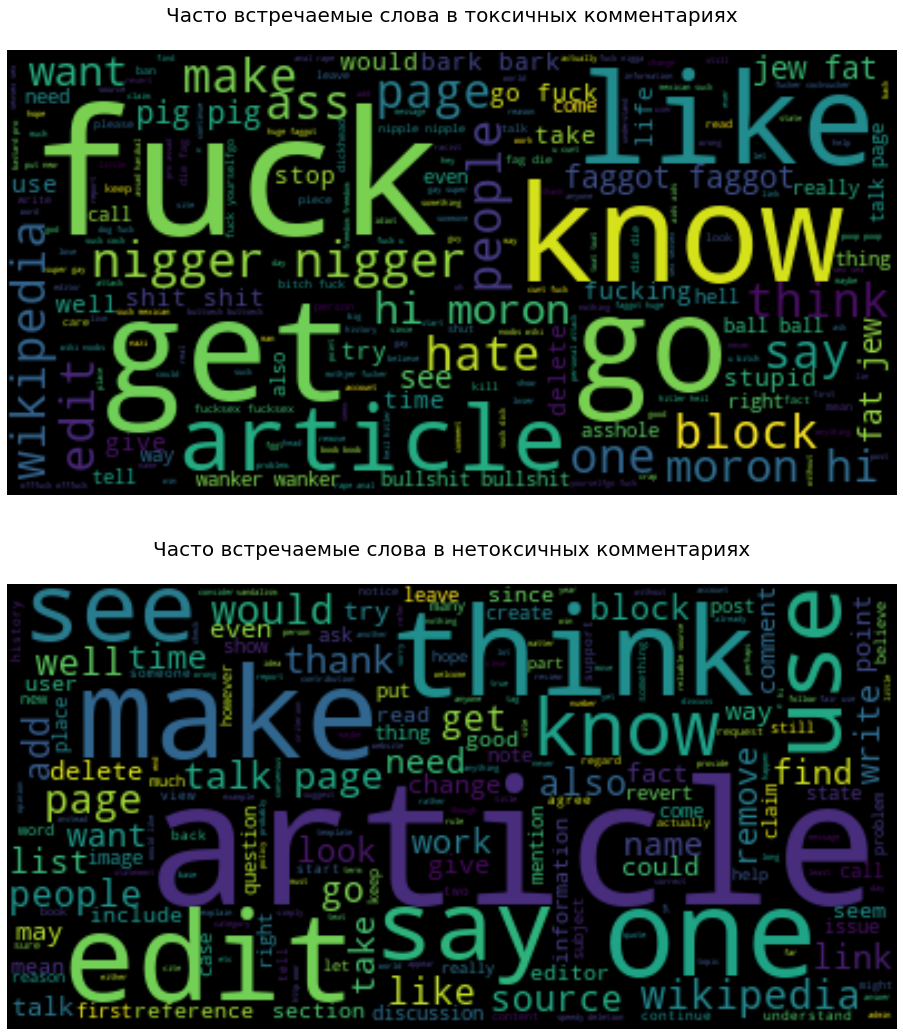

In [14]:
# построение облака слов
fig, axes = plt.subplots(2, 1, figsize=(18, 18))

axes[0].imshow(wordcloud_toxic, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Часто встречаемые слова в токсичных комментариях', fontsize=20, y=1.05)

axes[1].imshow(wordcloud_not_toxic, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title('Часто встречаемые слова в нетоксичных комментариях', fontsize=20, y=1.05)

plt.show()

Видно, что:
- в токсичных комментариях очень часто встречается слово, которое сразу приходит на ум при упоминании токсичных англоязычных слов - `fuck`, `go` - посылают, `like` - сравнивают, `get` - получают;
- в нетоксичных комментариях в основном: `make` - делают, `think` - думают, `say` - говорят, `see` - видят.
 
Теперь посмотрим на распределение целевого признака `toxic`:

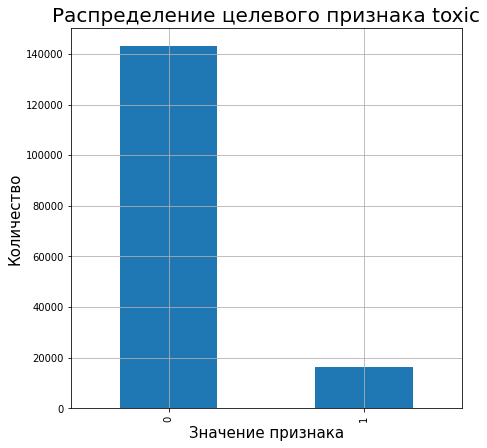

In [15]:
# график распределения целевого признака
toxic_comments_lemm.groupby(by='toxic')['toxic'].count().plot.bar(figsize=(7, 7), grid=True)
plt.title('Распределение целевого признака toxic', fontsize=20)
plt.ylabel('Количество', fontsize=15)
plt.xlabel(f'Значение признака', fontsize=15)
plt.show()

Есть большой дисбаланс классов, учтем это.

Разделим датафрейм на тренировочную, валидационную и тестовую выборки (в соотношении 3:1:1):

In [16]:
# разделение на тренировочную и валидационно-тестовую выборку
X_train, X_valid_test, y_train, y_valid_test = train_test_split(toxic_comments_lemm['lemm_text'], 
                                                                toxic_comments_lemm['toxic'],
                                                                random_state=42,
                                                                test_size=0.4,
                                                                stratify=toxic_comments_lemm['toxic'])

In [17]:
# разделение на валидационную и тестовую выборки
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size = 0.5, 
                                                    random_state = 42,
                                                    stratify=y_valid_test)

In [18]:
print(f'''
Размер тренировочной выборки X_train: {X_train.shape}
Размер тренировочного целевого признака y_train: {y_train.shape}
Доля токсичных комментариев в y_train: {(y_train.sum()/y_train.count()).round(2)}

Размер валидационной выборки X_valid: {X_valid.shape}
Размер валидационного целевого признака y_valid: {y_valid.shape}
Доля токсичных комментариев в y_valid: {(y_valid.sum()/y_valid.count()).round(2)}

Размер тестовой выборки X_test: {X_test.shape}
Размер тестового целевого признака y_test: {y_test.shape}
Доля токсичных комментариев в y_test: {(y_test.sum()/y_test.count()).round(2)}
''')


Размер тренировочной выборки X_train: (95575,)
Размер тренировочного целевого признака y_train: (95575,)
Доля токсичных комментариев в y_train: 0.1

Размер валидационной выборки X_valid: (31858,)
Размер валидационного целевого признака y_valid: (31858,)
Доля токсичных комментариев в y_valid: 0.1

Размер тестовой выборки X_test: (31859,)
Размер тестового целевого признака y_test: (31859,)
Доля токсичных комментариев в y_test: 0.1



Разделение прошло корректно, все соотношения соблюдены.

Теперь создадим пайплайн с подготовкой данных (избавление от слов, которые не несут смысловой нагрузки (`stopwords`) и расчет `TF-IDF`) и моделью:

In [19]:
# создание пайплайна
pipe = Pipeline([
    ('tf_idf', TfidfVectorizer(stop_words=stop_words)),
    ('model', DecisionTreeClassifier(random_state=42))]
)

Вывод по блоку подготовки данных:
- удален неинформативный признак;
- комментарии были очищены и лемматизированы;
- комментарии были разделены на тренировочную, валидационную и тестовую выборки с учетом дисбаланса целевого признака;
- создан пайпалйн для вычисления оценки важности слова `TF-IDF` для всех комментариев с моделью.

## Обучение

Проверим 4 модели классификации:
- `DecisionTreeClassifier`;
- `LogisticRegression`;
- `SGDClassifier`;
- `LGBMClassifier`.

### Модель DecisionTreeClassifier

Создаем словарь с гиперпараметрами для модели `DecisionTreeClassifier`:

In [20]:
# гиперпараметры для DecisionTreeClassifier
parameters_model_1 = {
    'model': [DecisionTreeClassifier(random_state=42)], # модель
    'model__class_weight': [None, 'balanced'], # веса классов
    'model__max_depth': [30, 40] # ограничение максимальной глубины дерева
}

Теперь создадим функцию для выбора лучшей модели с помощью `GridSearchCV`, выберем лучшую модель:

In [21]:
# функция для выбора лучшей модели
def best_model (model, parameters, X_train, y_train):
    # model - модель
    # parameters - гиперпараметры
    # X_train - тренировочная выборка
    # y_train - целевой признак
    
    # выбор лучшей модели с помощью GridSearchCV
    gs = GridSearchCV(
        model,
        parameters,
        cv=3,
        n_jobs=-1,
        scoring='f1'
    )

    # запуск поиска гиперпараметров
    gs.fit(X_train, y_train) 

    print(f'''
    Лучшие гиперпараметры: {gs.best_params_}
    Лучшая метрика f1: {round(gs.best_score_, 3)}
    ''')
    
    # возвращает лучшую модель
    return gs.best_estimator_

In [22]:
# выбор лучшей модели DecisionTreeClassifier
model_1_best = best_model(pipe, parameters_model_1, X_train, y_train)


    Лучшие гиперпараметры: {'model': DecisionTreeClassifier(max_depth=40, random_state=42), 'model__class_weight': None, 'model__max_depth': 40}
    Лучшая метрика f1: 0.698
    


Параметры лучшей модели `DecisionTreeClassifier` получились следующие:
- максимальная глубина дерева `max_depth` - 40;
- веса классов `class_weight` - `None`;
- лучшая метрика `f1` при кросс-валидации - 0,698.

Обучим лучшую модель на тренировочной выборке:

In [23]:
# обучение модели на тренировочных данных
model_1_best.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 DecisionTreeClassifier(max_depth=40, random_state=42))])

Получим предсказания на валидационной выборке и посмотрим на метрику `f1`:

In [24]:
# получение предсказаний
y_pred_model_1 = model_1_best.predict(X_valid)

print(f'Метрика f1 первой модели на валидационной выборке: {round(f1_score(y_valid, y_pred_model_1), 3)}')

Метрика f1 первой модели на валидационной выборке: 0.7


### Модель LogisticRegression

Создаем словарь с гиперпараметрами для модели `LogisticRegression`:

In [25]:
# гиперпараметры для LogisticRegression
parameters_model_2 = {
    'model': [LogisticRegression(random_state=42, max_iter=500)], # модель
    'model__class_weight': [None, 'balanced'], # веса классов
    'model__C': [1, 5, 10] # параметр С
}

Выберем лучшую модель `LogisticRegression`:

In [26]:
# выбор лучшей модели LogisticRegression
model_2_best = best_model(pipe, parameters_model_2, X_train, y_train)


    Лучшие гиперпараметры: {'model': LogisticRegression(C=10, max_iter=500, random_state=42), 'model__C': 10, 'model__class_weight': None}
    Лучшая метрика f1: 0.772
    


Параметры лучшей модели `LogisticRegression` получились следующие:
- параметр `С`- 10;
- веса классов `class_weight` - `None`;
- лучшая метрика `f1` при кросс-валидации - 0,772.

Обучим лучшую модель на тренировочной выборке:

In [27]:
# обучение модели на тренировочных данных
model_2_best.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LogisticRegression(C=10, max_iter=500, random_state=42))])

Получим предсказания на валидационной выборке и посмотрим на метрику `f1`:

In [28]:
# получение предсказаний
y_pred_model_2 = model_2_best.predict(X_valid)

print(f'Метрика f1 второй модели на валидационной выборке: {round(f1_score(y_valid, y_pred_model_2), 3)}')

Метрика f1 второй модели на валидационной выборке: 0.781


### Модель SGDClassifier

Создаем словарь с гиперпараметрами для модели `SGDClassifier`:

In [29]:
# гиперпараметры для SGDClassifier
parameters_model_3 = {
    'model': [SGDClassifier(random_state=42)], # модель
    'model__loss': ['hinge', 'log', 'modified_huber'], # функция потерь
    'model__class_weight': [None, 'balanced'], # веса классов
    'model__max_iter': [100, 500, 1000] # число итераций
}

Выберем лучшую модель `SGDClassifier`:

In [30]:
# выбор лучшей модели SGDClassifier
model_3_best = best_model(pipe, parameters_model_3, X_train, y_train)


    Лучшие гиперпараметры: {'model': SGDClassifier(class_weight='balanced', loss='modified_huber', max_iter=100,
              random_state=42), 'model__class_weight': 'balanced', 'model__loss': 'modified_huber', 'model__max_iter': 100}
    Лучшая метрика f1: 0.753
    


Параметры лучшей модели `SGDClassifier` получились следующие:
- функция потерь `loss` - `modified_huber`;
- веса классов `class_weight` - `balanced`;
- число итераций `max_iter` - 100;
- лучшая метрика `f1` при кросс-валидации - 0,753.

Обучим лучшую модель на тренировочной выборке:

In [31]:
# обучение модели на тренировочных данных
model_3_best.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               max_iter=100, random_state=42))])

Получим предсказания на валидационной выборке и посмотрим на метрику `f1`:

In [32]:
# получение предсказаний
y_pred_model_3 = model_3_best.predict(X_valid)

print(f'Метрика f1 третьей модели на валидационной выборке: {round(f1_score(y_valid, y_pred_model_3), 3)}')

Метрика f1 третьей модели на валидационной выборке: 0.752


### Модель LGBMClassifier

Создаем словарь с гиперпараметрами для модели `LGBMClassifier`:

In [33]:
# гиперпараметры для LGBMClassifier
parameters_model_4 = {
    'model': [LGBMClassifier(random_state=42)], # модель
    'model__max_depth': [5, 10], # максимальная глубина дерева
    'model__class_weight': [None, 'balanced'], # веса классов
    'model__n_estimators': [50, 100] # количество итераций
}

Выберем лучшую модель `LGBMClassifier`:

In [34]:
# выбор лучшей модели LGBMClassifier
model_4_best = best_model(pipe, parameters_model_4, X_train, y_train)


    Лучшие гиперпараметры: {'model': LGBMClassifier(class_weight='balanced', max_depth=10, random_state=42), 'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__n_estimators': 100}
    Лучшая метрика f1: 0.735
    


Параметры лучшей модели `LGBMClassifier` получились следующие:
- максимальная глубина дерева `max_depth` - 10;
- веса классов `class_weight` - `balanced`;
- число итераций `n_estimators` - 100;
- лучшая метрика `f1` при кросс-валидации - 0.735.

Обучим лучшую модель на тренировочной выборке:

In [35]:
# обучение модели на тренировочных данных
model_4_best.fit(X_train, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LGBMClassifier(class_weight='balanced', max_depth=10,
                                random_state=42))])

Получим предсказания на валидационной выборке и посмотрим на метрику `f1`:

In [36]:
# получение предсказаний
y_pred_model_4 = model_4_best.predict(X_valid)

print(f'Метрика f1 четвертой модели на валидационной выборке: {round(f1_score(y_valid, y_pred_model_4), 3)}')

Метрика f1 четвертой модели на валидационной выборке: 0.738


### Выбор лучшей модели

Сведем все результаты в одну таблицу:

In [37]:
# создание датафрейма с результатами
results = pd.DataFrame({'model':['DecisionTreeClassifier', 'LogisticRegression', 'SGDClassifier', 'LGBMClassifier'], 
                        'f1 при кросс-валидации':['0.698', '0.772', '0.753', '0.735'],
                        'f1 на валидационной выборке':['0.700', '0.781', '0.752', '0.738']})

results.sort_values(by='f1 на валидационной выборке', ascending=False).reset_index(drop=True)

,model,f1 при кросс-валидации,f1 на валидационной выборке
0,LogisticRegression,0.772,0.781
1,SGDClassifier,0.753,0.752
2,LGBMClassifier,0.735,0.738
3,DecisionTreeClassifier,0.698,0.700


Самая высокая метрика `f1` при кросс-валидации и на валидационной выборке у модели `LogisticRegression` ее и выберем, получим предсказания на тестовой выборке и посмотрим получившуюся метрику и построим матрицу ошибок:

Метрика f1 лучшей модели на тестовой выборке: 0.771


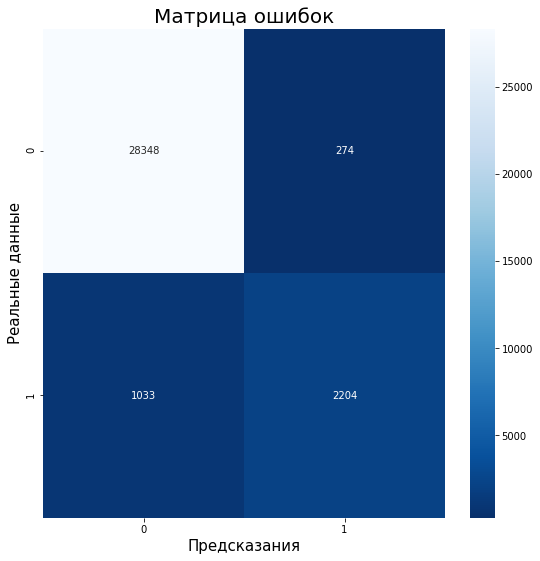

In [38]:
# вычисление метрикb f1
print(f'Метрика f1 лучшей модели на тестовой выборке: {round(f1_score(y_test, model_2_best.predict(X_test)), 3)}')

# построение матрицы ошибок
fig, axes = plt.subplots(figsize=(9, 9))
sns.heatmap(confusion_matrix(y_test, model_2_best.predict(X_test)), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные данные',fontsize=15)
plt.xlabel('Предсказания',fontsize=15)
plt.title('Матрица ошибок',fontsize=20)
plt.show()

Метрика `f1` на тренировочной выборке получилась 0,771 (это удовлетворяет критерию заказчика), но ложно-отрицательных предсказаний треть, получается, что каждый третий токсичный комментарий не будет попадать на модерацию, попробуем уменьшить их количество (уменьшенить ошибки второго рода), для этого поищем порог вероятности для присвоения первого класса, но так чтобы метрика `f1` все также удовлетворяла условию заказчика:

In [39]:
# функция для посика порога для уменьшения ошибок второго рода
def threshold_for_max_recall (model, X_test, y_test):
    # model - модель МО
    # X_test - Тренировочная выборка
    # y_test - целевой признак тренировочной выборки
    
    threshold = 0.500 
    f1 = 1
    
    # уменьшение порога пока f1 не станет меньше 0,75
    while f1 > 0.75:
        y_pred = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
        threshold -= 0.001
        f1 = f1_score(y_test, y_pred)
    
    print('Значение порога для уменьшения ошибок второго рода:', round(threshold, 3) + 0.002)

In [40]:
# получение порога
threshold_for_max_recall(model_2_best, X_valid, y_valid)

Значение порога для уменьшения ошибок второго рода: 0.143


Посмотрим на матрицу ошибок при пороге 0,143:

In [41]:
# поменяем порог вероятности принадлежности к классу 1 на 0,143 и получим новые предсказания
y_pred = np.where(model_2_best.predict_proba(X_test)[:,1] > 0.143, 1, 0)

Метрика f1 лучшей модели на тестовой выборке после уменьшения порога: 0.752


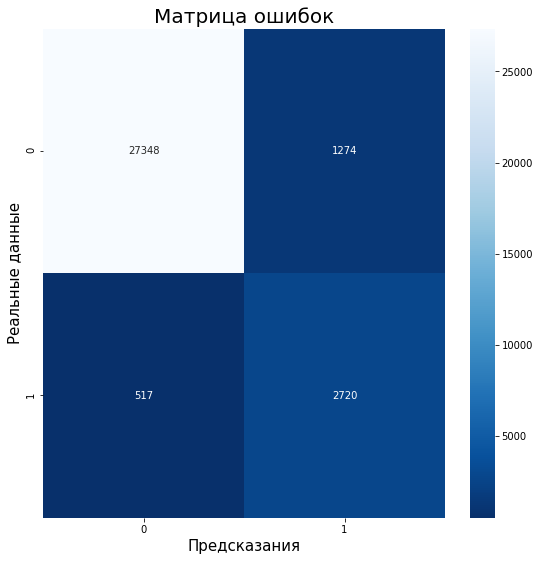

In [42]:
# вычисление метрику f1
print(f'Метрика f1 лучшей модели на тестовой выборке после уменьшения порога: {round(f1_score(y_test, y_pred), 3)}')

# построение матрицы ошибок
fig, axes = plt.subplots(figsize=(9, 9))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные данные',fontsize=15)
plt.xlabel('Предсказания',fontsize=15)
plt.title('Матрица ошибок',fontsize=20)
plt.show()

В два раза уменьшили количество ложно-отрицательных - это неплохо, но увеличилось количество ложно-положительных, но метрика `f1` - 0,752 все еще удовлетворяеет условию заказчика.

## Выводы

В данном проекте для получения модели классификации комментариев на позитивные и негативные был проведена подготовка данных: 
- удален неинформативный признак;
- комментарии были очищены и лемматизированы;
- комментарии были разделены на тренировочную, валидационную и тестовую выборки с учетом дисбаланса целевого признака;
- создан пайпалйн для вычисления оценки важности слова `TF-IDF` для всех комментариев с моделью.

Далее из 4 моделей была на основе метрики `f1` была выбрана лучшая, ей оказалась модель `LogisticRegression` со следующими параметрами:
- параметр `С`- 10;
- веса классов `class_weight` - `None`;
- лучшая метрика `f1` при кросс-валидации - 0,772;
- лучшая метрика на валидационной выборке - 0,781.

Метрика `f1` на тестовой выборке получилась: **0,771**.

Для уменьшения ложно-отрицательных предсказаний был уменьшен порог вероятности (до 0,143) для отнесения к классу 1, и в итоге метрика `f1` на тестовой выборке уменьшилась до минимально допустимой заказчиком: **0,752**.